In [1]:
!pip install pvlib
!pip install cpvlib

import matplotlib.pyplot as plt
import pvlib

from cpvlib import cpvsystem

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\ruben\\miniconda3\\lib\\site-packages\\numpy-1.21.1.dist-info\\METADATA'



  Using cached numpy-1.20.0-cp37-cp37m-win_amd64.whl (13.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1


ERROR: Cannot uninstall numpy 1.21.1, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps numpy==1.21.1'.
C:\Users\Ruben\Miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ruben\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\Ruben\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# XX m2, XXX III-V cells (12 serie x XX parallel) micro-cells + XX Y"(ZZ cm) Si-cells in series
# https://doi.org/10.5281/zenodo.3349781
# 35 range IV: 0.7 A, 35 V @DNI 900 W/m2
# Si range IV: 1.7 A, 2.2 V @GNI 950 W/m2 & DNI/GNI=0.7

# https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.calcparams_pvsyst.html

# mod 191
mod_params_cpv = {
    "gamma_ref": 5.25, # Voltage adjustment. Previous 5.524
    "mu_gamma": 0.0004,
    "I_L_ref": 0.97*5,
    "I_o_ref": 1.7e-10, 
    "R_sh_ref": 5226,
    "R_sh_0": 21000,
    "R_sh_exp": 5.50,
    "R_s": 0.01,
    "alpha_sc": 0.00,
    "EgRef": 3.94,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 12,
    "eta_m": 0.32,
    "alpha_absorption": 0.9,
    #"b": 0.7,
    "iam_model": 'interp',
    "theta_ref": [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 54, 55, 56,90],
    "iam_ref": [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.1, 0.002,0.001],
}

UF_parameters_cpv = {
    "IscDNI_top": 1,
    "am_thld": 1.25,
    "am_uf_m_low": 0.4, #0.175
    "am_uf_m_high": -0.5,  
    "ta_thld": 15, #original 15.2
    "ta_uf_m_low": 0.0, 
    "ta_uf_m_high": -0.00, 
    "weight_am": 1,
    "weight_temp": 0,
}

mod_params_cpv.update(UF_parameters_cpv)

# mod 120
mod_params_flatplate = {
    "gamma_ref": 1.1, #ideality factor
    "mu_gamma": -0.0003,
    "I_L_ref": 2.05,
    "I_o_ref": 1.5e-10,
    "R_sh_ref": 200,
    "R_sh_0": 600, # 4 times Rsh_ref typically acc. PVSYST
    "R_sh_exp": 5.5,
    "R_s": 0.6, #standard value
    "alpha_sc": 0,
    "EgRef": 1.121,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 64, # 8*8,
    "eta_m": 0.2,  # module efficiency for pvlib.temperature.pvsyst_cell
    "alpha_absorption": 0.6,  # more light is absorbed in the front cover than in conventional flat plate
    "aoi_limit": 40, #should be 55°, but tracking mechanism is not working welll
    "iam_model": 'interp',
    "theta_ref": [0, 5, 15, 25, 35, 45,  55,   65,   70,   80,   85, 90],
    "iam_ref":   [1, 1, 1,  1,  1,  1, 0.95,  0.7,  0.5,  0.5,  0.5, 0],
    # "iam_ref": [1,  1,  0.9918,  0.9815,  0.9721,  0.9485,  0.9071,  0.6072,  0.00365,  0,  0] #THEIA cSI notebook
    
    "theta_ref_spillage": [0, 10, 20, 30, 40,  55, 90],
    "iam_ref_spillage": [1, 1, 1.02, 1.16,  1.37, 1.37, 1.37]
}

In [3]:
heat_dissipation_params_CPV = {'model': 'pvsyst', 'u_c': 29, 'u_v': 0.05} # insulated is 15, freestanding is 29
heat_dissipation_params_flatplate = {'model': 'pvsyst', 'u_c': 24, 'u_v': 0.05}

lat, lon = 40.4, -3.7

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

data = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data.set_index(
    data.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=695, tz='utc')

solar_zenith = location.get_solarposition(data.index).zenith
solar_azimuth = location.get_solarposition(data.index).azimuth

StaticHybridSystem

In [4]:
static_hybrid_sys = cpvsystem.StaticHybridSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_cpv=None,
    module_flatplate=None,
    module_parameters_cpv=mod_params_cpv,
    module_parameters_flatplate=mod_params_flatplate,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    temperature_model_parameters_cpv=heat_dissipation_params_CPV,
    temperature_model_parameters_flatplate=heat_dissipation_params_flatplate,
    # racking_model="freestanding", #not used because temp model parameters are already defined
    losses_parameters=None,
    name=None,
)

get_effective_irradiance

In [5]:
data['dii_effective'], data['poa_flatplate_static_effective'] = static_hybrid_sys.get_effective_irradiance(
    solar_zenith,
    solar_azimuth,
    dii=None,
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni'],
    spillage=0.15 # Percentage of direct irradiance allowed to the flat plate within AOI range. This number comes from module 120.
    # Spillage is highly dependent on the tracking accuracy of each module.
)


pvsyst_celltemp

In [6]:
data['temp_cell_35'], data['temp_cell_flatplate'] = static_hybrid_sys.pvsyst_celltemp(
    dii=data['dii_effective'],
    poa_flatplate_static=data['poa_flatplate_static_effective'] + data['dii_effective'], # It is very important to add direct light as well
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

calcparams_pvsyst

In [7]:
diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
    dii=data['dii_effective'],
    poa_flatplate_static=data['poa_flatplate_static_effective'],
    temp_cell_cpv=data['temp_cell_35'],
    temp_cell_flatplate=data['temp_cell_flatplate'],
)

singlediode

In [8]:
dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
    diode_parameters_cpv, diode_parameters_flatplate)

uf_global (uf_am, uf_temp_air)

In [9]:
data['am'] = location.get_airmass(data.index).airmass_absolute
uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(data['am'], data['temp_air'])

Power

<AxesSubplot:xlabel='time(UTC)'>

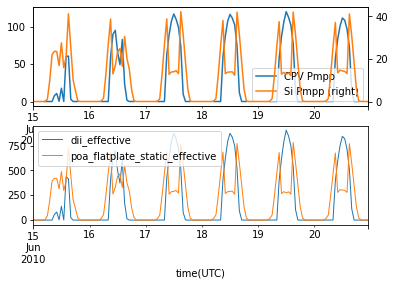

In [10]:
cpv_days = dc_cpv['2010-06-15':'2010-06-20']
uf_cpv_days = uf_cpv['2010-06-15':'2010-06-20']
flatplate_days = dc_flatplate['2010-06-15':'2010-06-20']
data_days = data['2010-06-15':'2010-06-20']

fig, axs = plt.subplots(2)

(cpv_days.p_mp * uf_cpv_days).plot(ax=axs[0], legend=True, label="CPV Pmpp")
flatplate_days.p_mp.plot(ax=axs[0], secondary_y=True, legend=True, label="Si Pmpp")
data_days[['dii_effective', 'poa_flatplate_static_effective']].plot(ax=axs[1], linewidth=1)

Energy

In [11]:
energy_cpv = (dc_cpv['p_mp'] * uf_cpv).sum()
energy_flatplate = dc_flatplate['p_mp'].sum()

print(f"E_CPV={energy_cpv:.0f} Wh", f"E_diff={energy_flatplate:.0f} Wh")

E_CPV=146219 Wh E_diff=66984 Wh
